In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

# ---- Patch for new Keras versions ----
import keras
import types

if not hasattr(keras.utils, 'get_custom_objects'):
    from keras.utils import get_custom_objects
    keras.utils.get_custom_objects = get_custom_objects

keras.utils.generic_utils = types.SimpleNamespace(
    get_custom_objects=keras.utils.get_custom_objects
)
# --------------------------------------

# Import segmentation_models with patched keras
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

# Import efficientnet with tf.keras backend
import efficientnet.tfkeras

from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

# Dataset path
root_directory = '/content/drive/MyDrive/Semantic segmentation dataset'
patch_size = 256

# Check if the directory exists
if os.path.exists(root_directory):
    print("Checking root directory:", root_directory)
    print("Subdirectories:", os.listdir(root_directory))
else:
    print(f"Error: Directory '{root_directory}' not found. Please verify the path.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Segmentation Models: using `keras` framework.
Checking root directory: /content/drive/MyDrive/Semantic segmentation dataset
Subdirectories: ['classes.json', 'Tile 8', 'Tile 7', 'Tile 6', 'Tile 5', 'Tile 4', 'Tile 2', 'Tile 3', 'Tile 1']


In [2]:
image_dataset = []
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):
            if image_name.endswith('.jpg'):
                image_path = path + '/' + image_name  # Get the full image path
                image = cv2.imread(image_path, 1)

                # Calculate crop dimensions ONCE, based on the image:
                SIZE_X = (image.shape[1] // patch_size) * patch_size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size

                # Crop the image
                image = Image.fromarray(image)
                image = image.crop((0, 0, SIZE_X, SIZE_Y))
                image = np.array(image)

                # Find corresponding mask (assumes naming convention)
                mask_path = image_path.replace('/images/', '/masks/').replace('.jpg', '.png')
                mask = cv2.imread(mask_path, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

                # Crop the mask using SAME dimensions
                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
                mask = np.array(mask)

                # Now patchify:
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i, j, :, :]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)

                        single_patch_mask = patches_mask[i, j, :, :]
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask)  # Append mask patch here


image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)


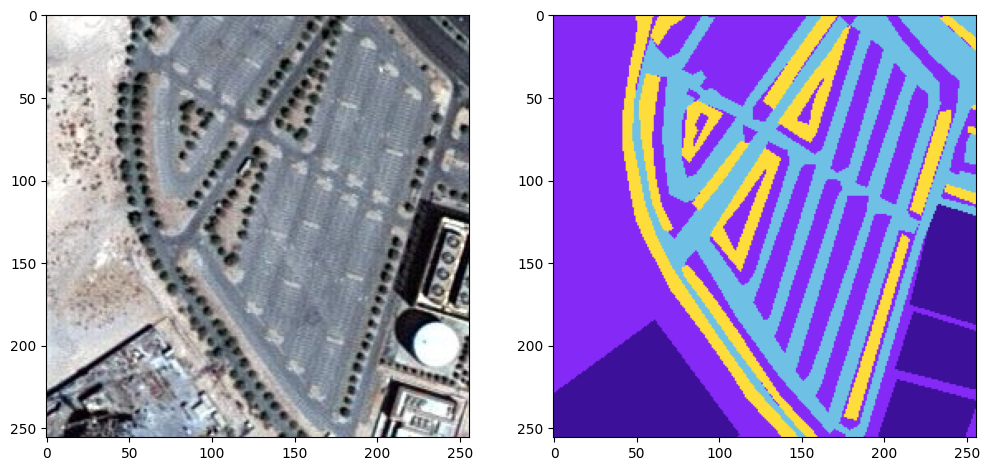

In [3]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [4]:
# Convert HEX to RGB array
# a = int ('3C', 16)    # 3C with base 16. Should return 60
# print(a)

#Do the same for all RGB channels in each HEX code to RGB

Building = '#3C1098'.lstrip('#')
Buuilding = np.array(tuple(int(Building[i:i+2], 16) for i in (0,2,4)))

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0,2,4)))

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0,2,4)))

Vegetation = '#FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0,2,4)))

Water = '#E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0,2,4)))

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0,2,4)))

label = single_patch_mask



# Now replace RGB to integer values to be used as labels
# Find pixels with combination of RGB for the above defined arrays
# If matches then replace all values in that pixel with a specific integer


def rgb_to_2D_label(label):

  label_seg = np.zeros(label.shape,dtype=np.uint8)
  label_seg[np.all(label == Building, axis=-1)] = 0
  label_seg[np.all(label == Land, axis=-1)] = 1
  label_seg[np.all(label == Road, axis=-1)] = 2
  label_seg[np.all(label == Vegetation, axis=-1)] = 3
  label_seg[np.all(label == Water, axis=-1)] = 4
  label_seg[np.all(label == Unlabeled, axis=-1)] = 5

  label_seg = label_seg[:,:,0]

  return label_seg


labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_2D_label(mask_dataset[i])
  labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are:", np.unique(labels))



Unique labels in label dataset are: [0 1 2 3 4 5]


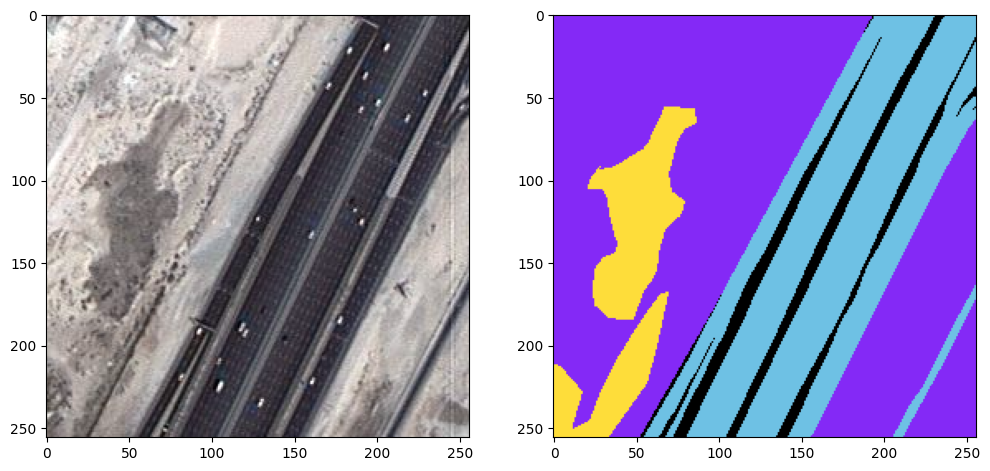

In [5]:
# Just to check if the images and masks are still matching after all the conversions

import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [6]:
# Standard U-Net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
  # Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = inputs

  # Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  # Expansive Path

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the training  section
  return model



TPU is not available, using default strategy
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                 

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85521592/85521592 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                           

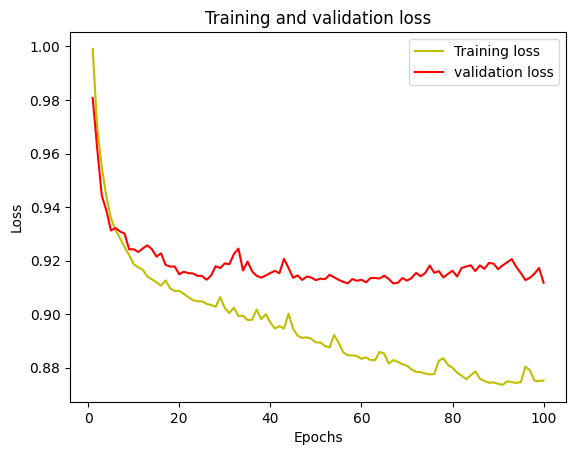

In [7]:


import tensorflow as tf

# Check if TPU is available
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU is available")
except ValueError:
  print("TPU is not available, using default strategy")
  strategy = tf.distribute.get_strategy()

# Import to_categorical here
from tensorflow.keras.utils import to_categorical # This line imports the missing function

with strategy.scope(): # This line is crucial for using TPUs
  n_classes = len(np.unique(labels))
  labels_cat = to_categorical(labels, num_classes=n_classes)
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


  # Parameters for the model
  weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
  dice_loss = sm.losses.DiceLoss(class_weights=weights)
  focal_loss = sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)

  IMG_HEIGHT = image_dataset.shape[1]
  IMG_WIDTH  = image_dataset.shape[2]
  IMG_CHANNELS = image_dataset.shape[3]

  metrics = ['accuracy', jacard_coef]

  def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

  model = get_model()
  model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
  model.summary()


  history1 = model.fit(X_train, y_train, batch_size = 16, verbose=1, epochs=100 , validation_data=(X_test, y_test), shuffle=False)

  # Now save this trained model (1st)
  model.save("models/satellite_standard_unet_100epochs.hdf5")




  BACKBONE = 'resnet34'
  preprocess_input = sm.get_preprocessing(BACKBONE)

  # preprocess input
  X_train = preprocess_input(X_train)
  X_test = preprocess_input(X_test)

  # define model
  model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

  # compile keras
  model_resnet_backbone.compile(optimizer='adam', loss=total_loss, metrics=metrics)
  print(model_resnet_backbone.summary())

  history2 = model_resnet_backbone.fit(X_train, y_train, batch_size = 16, verbose=1, epochs=100, validation_data=(X_test, y_test))

  # now save this trained model (2nd)
  model_resnet_backbone.save("models/satellite_resnet_unet_100epochs.hdf5")


# for plotting training and validation accuracy and loss at each epoch

history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





COMPARISON OF RESNET UNET AND STANDARD UNET


✅ Standard UNet loaded
✅ ResNet-UNet loaded
1/1 [==============================] - 1s 847ms/step
Mean IoU (Standard UNet): 0.5261
Mean IoU (ResNet-UNet): 0.5585


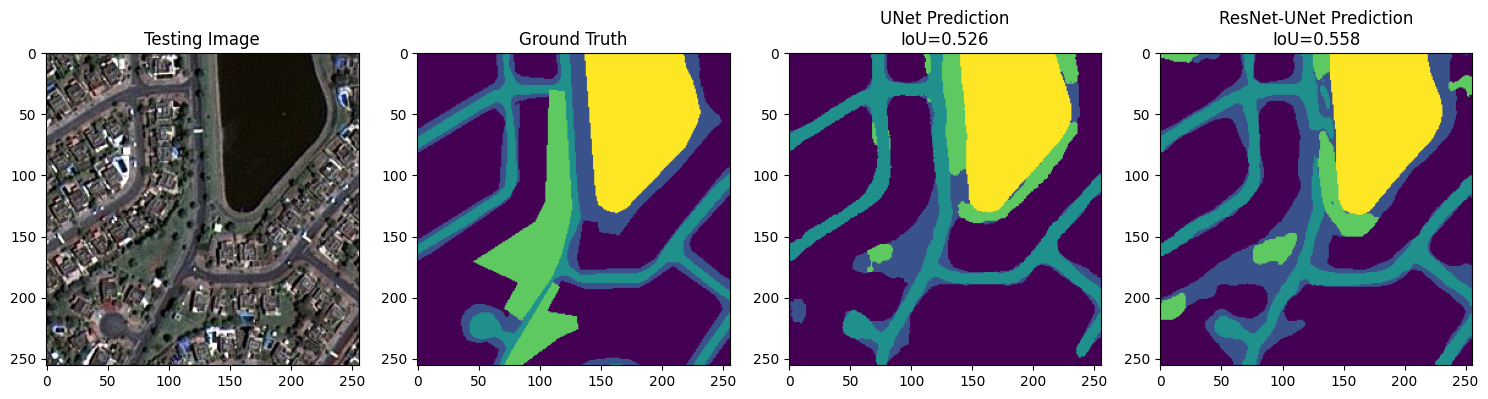

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
import random

#  Paths to saved models
unet_path = "/content/models/satellite_standard_unet_100epochs.hdf5"
resnet_unet_path = "/content/models/satellite_resnet_unet_100epochs.hdf5"

#  Load both models
unet_model = load_model(
    unet_path,
    custom_objects={
        'dice_loss_plus_1focal_loss': total_loss,
        'jacard_coef': jacard_coef,
        'DiceLoss': sm.losses.DiceLoss,  # Add DiceLoss to custom_objects
        'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss # Add CategoricalFocalLoss to custom_objects

    }
)
print("✅ Standard UNet loaded")

resnet_unet_model = load_model(
    resnet_unet_path,
    custom_objects={
        'dice_loss_plus_1focal_loss': total_loss,
        'jacard_coef': jacard_coef,
        'DiceLoss': sm.losses.DiceLoss,  # Add DiceLoss to custom_objects
        'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss # Add CategoricalFocalLoss to custom_objects
    }
)
print("✅ ResNet-UNet loaded")

#  Pick a random test image
rand_idx = random.randint(0, len(X_test) - 1)
test_img = X_test[rand_idx]
ground_truth = np.argmax(y_test[rand_idx], axis=-1)  # Convert one-hot to class IDs

#  Predict with both models
test_img_input = np.expand_dims(test_img, 0)

# Standard UNet prediction
pred_unet = unet_model.predict(test_img_input)
pred_unet_mask = np.argmax(pred_unet, axis=3)[0, :, :]

# ResNet UNet prediction
pred_resnet = resnet_unet_model.predict(test_img_input)
pred_resnet_mask = np.argmax(pred_resnet, axis=3)[0, :, :]

#  Compute IoU for each
n_classes = 6
IoU_unet = MeanIoU(num_classes=n_classes)
IoU_unet.update_state(ground_truth, pred_unet_mask)
iou_score_unet = IoU_unet.result().numpy()

IoU_resnet = MeanIoU(num_classes=n_classes)
IoU_resnet.update_state(ground_truth, pred_resnet_mask)
iou_score_resnet = IoU_resnet.result().numpy()

print(f"Mean IoU (Standard UNet): {iou_score_unet:.4f}")
print(f"Mean IoU (ResNet-UNet): {iou_score_resnet:.4f}")

#  Plot comparison
plt.figure(figsize=(15, 8))

plt.subplot(1, 4, 1)
plt.title('Testing Image')
plt.imshow(test_img)

plt.subplot(1, 4, 2)
plt.title('Ground Truth')
plt.imshow(ground_truth)

plt.subplot(1, 4, 3)
plt.title(f'UNet Prediction\nIoU={iou_score_unet:.3f}')
plt.imshow(pred_unet_mask)

plt.subplot(1, 4, 4)
plt.title(f'ResNet-UNet Prediction\nIoU={iou_score_resnet:.3f}')
plt.imshow(pred_resnet_mask)

plt.tight_layout()
plt.show()

--------------------------------------------FINAL-----------------------------


✅ Model loaded from: /content/models/satellite_resnet_unet_100epochs.hdf5
9/9 [==============================] - 8s 752ms/step
Mean IoU = 0.61351085
1/1 [==============================] - 0s 76ms/step


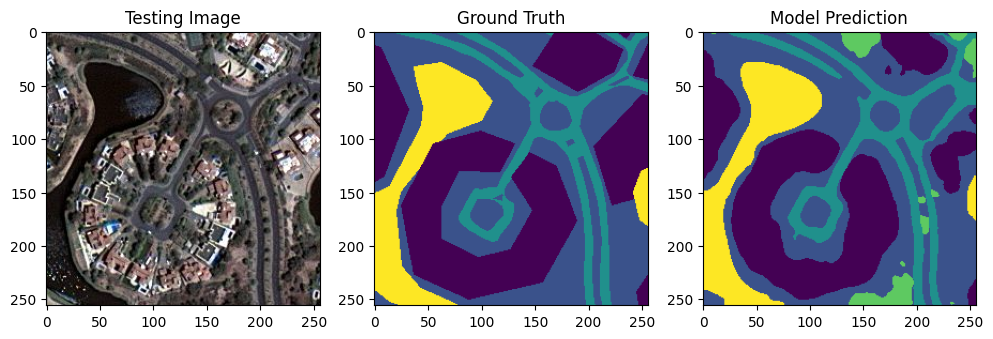

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU


weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


# Load model from Google Drive
model_path = "/content/models/satellite_resnet_unet_100epochs.hdf5"
model = load_model(
    model_path,
    custom_objects={
        'dice_loss_plus_1focal_loss': total_loss,
        'jacard_coef': jacard_coef,
        'DiceLoss': sm.losses.DiceLoss,  # Add DiceLoss to custom_objects
        'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss # Add CategoricalFocalLoss to custom_objects
    }
)
print("✅ Model loaded from:", model_path)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

# Compute Mean IoU
n_classes = 6
IoU_keras = MeanIoU(num_classes=n_classes)
IoU_keras.update_state(np.argmax(y_test, axis=3), y_pred_argmax)
print("Mean IoU =", IoU_keras.result().numpy())

# Predict on a random image
import random
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth = np.argmax(y_test[test_img_number], axis=-1)

test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Model Prediction')
plt.imshow(predicted_img)
plt.show()